# Escribir Ensayos

In [2]:
from langgraph.graph import StateGraph, END
import sqlite3
from typing import TypedDict, Annotated, List
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
memory = SqliteSaver(sqlite3.connect(":memory:", check_same_thread=False))
# memory = SqliteSaver.from_conn_string(":memory:")

In [3]:
# Se importa TypedDict desde el módulo typing para definir un tipo de diccionario con claves específicas y valores
# tipados

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

In [4]:
from langchain_openai import ChatOpenAI
import os
ChatOpenAI.api_key = os.getenv("OPENAI_API_KEY")
model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
PLAN_PROMPT = """Eres un escritor experto encargado de redactar un esquema de alto nivel para un ensayo. \
Escribe dicho esquema para el tema proporcionado por el usuario. Proporciona un esquema del ensayo junto \
con cualquier nota relevante o instrucciones para las secciones. Máximo 100 palabras."""

In [5]:
WRITER_PROMPT = """Eres un asistente de ensayos encargado de escribir excelentes ensayos de 2 párrafos (máximo 50 palabras cada uno). \
Genera el mejor ensayo posible para la solicitud del usuario y el esquema inicial. \
Si el usuario proporciona una crítica, responde con una versión revisada de tus intentos anteriores. \
Utiliza toda la información a continuación según sea necesario: 

------

{content}"""

In [6]:
REFLECTION_PROMPT = """Eres un profesor evaluando la entrega de un ensayo. \
Genera una crítica y recomendaciones para la entrega del usuario. \
Proporciona recomendaciones detalladas, incluyendo peticiones sobre la longitud, profundidad, estilo, etc. (máximo 100 palabras)."""

In [7]:
RESEARCH_PLAN_PROMPT = """Eres un investigador encargado de proporcionar información que pueda \
ser utilizada al escribir el siguiente ensayo. Genera una lista de consultas de búsqueda que recojan \
cualquier información relevante. Solo genera un máximo de 2 consultas (máximo 100 palabras)."""


In [8]:
RESEARCH_CRITIQUE_PROMPT = """Eres un investigador encargado de proporcionar información que pueda \
ser utilizada al realizar las revisiones solicitadas (como se detalla a continuación). \
Genera una lista de consultas de búsqueda que recojan cualquier información relevante. \
Solo genera un máximo de 2 consultas (máximo 100 palabras).
"""


In [9]:
from pydantic import BaseModel

class Queries(BaseModel):
    queries: List[str]

In [10]:
from tavily import TavilyClient
import os
tavily = TavilyClient(api_key=os.environ["TAVILY_API_KEY"])

In [11]:
def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT), 
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

In [12]:
def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [13]:
def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nEste es mi plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content, 
        "revision_number": state.get("revision_number", 1) + 1
    }


In [14]:
def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT), 
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

In [15]:
def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state.get('content', [])
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

In [16]:
def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [17]:
builder = StateGraph(AgentState)

In [18]:
builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

In [19]:
builder.set_entry_point("planner")

In [20]:
builder.add_conditional_edges(
    "generate", 
    should_continue, 
    {END: END, "reflect": "reflect"}
)


In [21]:
builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

In [22]:
# from langgraph.checkpoint.memory import MemorySaver
# memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

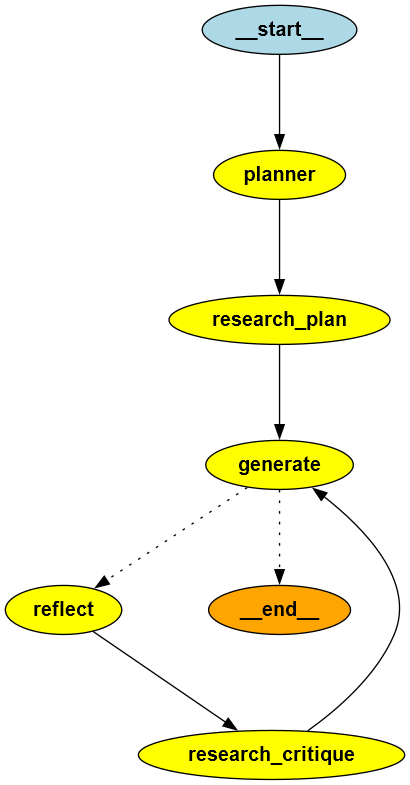

In [23]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [24]:
from IPython.display import display, Markdown

# Simulación del stream y de las salidas
thread = {"configurable": {"thread_id": "1"}}

# Función para generar una salida más bonita
def print_pretty_output():
    for s in graph.stream({
        'task': "Cual es la diferencia entre windows y linux",
        "max_revisions": 2,
        "revision_number": 1,
    }, thread):
        # Usamos Markdown para mejorar la presentación
        display(Markdown(f"### Respuesta del sistema: \n\n{s}"))

# Llamar la función
print_pretty_output()

### Respuesta del sistema: 

{'planner': {'plan': '**Esquema del ensayo: "Diferencias entre Windows y Linux"**\n\nI. Introducción  \n   A. Presentación del tema  \n   B. Importancia de entender las diferencias  \n\nII. Historia y desarrollo  \n   A. Orígenes de Windows  \n   B. Orígenes de Linux  \n\nIII. Estructura y arquitectura  \n   A. Sistema de archivos en Windows  \n   B. Sistema de archivos en Linux  \n\nIV. Interfaz de usuario  \n   A. Diseño y usabilidad de Windows  \n   B. Diseño y usabilidad de Linux  \n\nV. Seguridad  \n   A. Vulnerabilidades en Windows  \n   B. Seguridad en Linux  \n\nVI. Comunidad y soporte  \n   A. Soporte técnico en Windows  \n   B. Comunidad de usuarios de Linux  \n\nVII. Conclusión  \n   A. Resumen de diferencias clave  \n   B. Reflexión sobre la elección entre ambos sistemas  \n\n*Nota: Incluir ejemplos y estadísticas relevantes en cada sección para fortalecer los argumentos.*'}}

### Respuesta del sistema: 

{'research_plan': {'content': ['En este artículo, exploraremos las principales diferencias entre Windows y Linux, para ayudarte a elegir el sistema operativo ideal para ti. Una de las principales diferencias entre Windows y Linux es la estabilidad y el rendimiento de los sistemas operativos. Cada distribución de Linux puede tener una interfaz de usuario diferente y personalizable, lo que permite a los usuarios adaptar el aspecto y la funcionalidad de su sistema operativo según sus preferencias. En última instancia, la elección entre Windows y Linux como sistema operativo depende de las necesidades y preferencias individuales del usuario. Linux, por otro lado, es una excelente opción para aquellos que valoran el software libre, la personalización y la estabilidad.', 'Linux y Windows son dos sistemas operativos muy populares en la actualidad, pero existen diferencias clave entre ellos que es importante tener en cuenta al momento de elegir cuál utilizar. Linux es generalmente considerado como un sistema operativo más seguro debido a su arquitectura y la forma en que los permisos de usuario son manejados. Linux es un sistema operativo de código abierto que ha ganado popularidad en los últimos años debido a su estabilidad, seguridad y flexibilidad. Una de las diferencias más importantes entre Linux y otros sistemas operativos es su licencia. Windows, por otro lado, es un sistema operativo comercial, propietario y enfocado en la facilidad de uso para el usuario promedio.', 'WindowsLinuxInterfaz de usuarioGUI orientada al usuario medio, con opciones limitadas de personalización fuera de temas predefinidos.Altamente personalizable con múltiples entornos de escritorio.Modelo de distribución y licenciaPrivado, requiere compra o licencia.Open Source, gratuito para descargar y usar.Seguridad y estabilidadVulnerable a malware, aunque con mejoras en versiones recientes.Más seguro y estable debido a su menor cuota de mercado y diseño.Compatibilidad de software y hardwareAmplio soporte de hardware y software gracias a su dominio en el mercado.Compatible con una amplia gama de hardware, aunque algunos softwares específicos no están disponibles.Soporte y comunidadSoporte técnico formal a través de Microsoft y una gran cantidad de documentación y foros de usuarios.Soporte comunitario a través de foros y documentación en línea, pero sin soporte técnico oficial. En la cara B, encontramos que Linux puede presentar una curva de aprendizaje más pronunciada para los usuarios acostumbrados a otros sistemas operativos debido a su diversidad de entornos de escritorio y opciones de configuración.', 'Por otro lado, es lógico que los hackers pongan la diana de sus ataques (virus y malware) en el sistema operativo que cuenta con más usuarios a nivel global. Dicho de otro modo: Linux se presenta a sus usuarios en distintas formas (la más conocida es Ubuntu), lo cual es al mismo tiempo una virtud, ya que ofrece más opciones a los usuarios, pero también un defecto, pues esto supone también un lastre a la hora de competir con el gigante de Microsoft. Pero el hecho de ser considerada Linux una plataforma destinada a un público limitado encierra en sí mismo una gran desventaja: el software compatible disponible es mucho más reducido que el que está al alcance de los usuarios de Windows.']}}

### Respuesta del sistema: 

{'generate': {'draft': '**Diferencias entre Windows y Linux**\n\nWindows y Linux son dos sistemas operativos que se destacan por sus características únicas. Windows, desarrollado por Microsoft, es conocido por su interfaz amigable y su amplia compatibilidad de software, lo que lo convierte en la opción preferida para usuarios promedio. En contraste, Linux, un sistema de código abierto, ofrece una personalización superior y es valorado por su estabilidad y seguridad, aunque puede presentar una curva de aprendizaje más pronunciada.\n\nLa elección entre Windows y Linux depende de las necesidades individuales del usuario. Mientras que Windows es ideal para quienes buscan facilidad de uso y soporte técnico formal, Linux es perfecto para aquellos que valoran la personalización y la comunidad de usuarios. En última instancia, comprender estas diferencias es crucial para tomar una decisión informada sobre qué sistema operativo se adapta mejor a tus requerimientos.', 'revision_number': 2}}

### Respuesta del sistema: 

{'reflect': {'critique': 'Tu ensayo presenta una comparación clara entre Windows y Linux, pero podría beneficiarse de mayor profundidad y análisis. Te recomiendo ampliar la discusión sobre las ventajas y desventajas de cada sistema operativo, incluyendo ejemplos concretos de aplicaciones o situaciones en las que uno podría ser preferible al otro. Además, considera incluir estadísticas o estudios que respalden tus afirmaciones. \n\nEn cuanto al estilo, intenta utilizar un lenguaje más formal y técnico, y asegúrate de que la longitud sea de al menos 800 palabras para un análisis más completo. Por último, revisa la gramática y la estructura para mejorar la fluidez del texto.'}}

### Respuesta del sistema: 

{'research_critique': {'content': ['En este artículo, exploraremos las principales diferencias entre Windows y Linux, para ayudarte a elegir el sistema operativo ideal para ti. Una de las principales diferencias entre Windows y Linux es la estabilidad y el rendimiento de los sistemas operativos. Cada distribución de Linux puede tener una interfaz de usuario diferente y personalizable, lo que permite a los usuarios adaptar el aspecto y la funcionalidad de su sistema operativo según sus preferencias. En última instancia, la elección entre Windows y Linux como sistema operativo depende de las necesidades y preferencias individuales del usuario. Linux, por otro lado, es una excelente opción para aquellos que valoran el software libre, la personalización y la estabilidad.', 'Linux y Windows son dos sistemas operativos muy populares en la actualidad, pero existen diferencias clave entre ellos que es importante tener en cuenta al momento de elegir cuál utilizar. Linux es generalmente considerado como un sistema operativo más seguro debido a su arquitectura y la forma en que los permisos de usuario son manejados. Linux es un sistema operativo de código abierto que ha ganado popularidad en los últimos años debido a su estabilidad, seguridad y flexibilidad. Una de las diferencias más importantes entre Linux y otros sistemas operativos es su licencia. Windows, por otro lado, es un sistema operativo comercial, propietario y enfocado en la facilidad de uso para el usuario promedio.', 'WindowsLinuxInterfaz de usuarioGUI orientada al usuario medio, con opciones limitadas de personalización fuera de temas predefinidos.Altamente personalizable con múltiples entornos de escritorio.Modelo de distribución y licenciaPrivado, requiere compra o licencia.Open Source, gratuito para descargar y usar.Seguridad y estabilidadVulnerable a malware, aunque con mejoras en versiones recientes.Más seguro y estable debido a su menor cuota de mercado y diseño.Compatibilidad de software y hardwareAmplio soporte de hardware y software gracias a su dominio en el mercado.Compatible con una amplia gama de hardware, aunque algunos softwares específicos no están disponibles.Soporte y comunidadSoporte técnico formal a través de Microsoft y una gran cantidad de documentación y foros de usuarios.Soporte comunitario a través de foros y documentación en línea, pero sin soporte técnico oficial. En la cara B, encontramos que Linux puede presentar una curva de aprendizaje más pronunciada para los usuarios acostumbrados a otros sistemas operativos debido a su diversidad de entornos de escritorio y opciones de configuración.', 'Por otro lado, es lógico que los hackers pongan la diana de sus ataques (virus y malware) en el sistema operativo que cuenta con más usuarios a nivel global. Dicho de otro modo: Linux se presenta a sus usuarios en distintas formas (la más conocida es Ubuntu), lo cual es al mismo tiempo una virtud, ya que ofrece más opciones a los usuarios, pero también un defecto, pues esto supone también un lastre a la hora de competir con el gigante de Microsoft. Pero el hecho de ser considerada Linux una plataforma destinada a un público limitado encierra en sí mismo una gran desventaja: el software compatible disponible es mucho más reducido que el que está al alcance de los usuarios de Windows.', 'WindowsLinuxInterfaz de usuarioGUI orientada al usuario medio, con opciones limitadas de personalización fuera de temas predefinidos.Altamente personalizable con múltiples entornos de escritorio.Modelo de distribución y licenciaPrivado, requiere compra o licencia.Open Source, gratuito para descargar y usar.Seguridad y estabilidadVulnerable a malware, aunque con mejoras en versiones recientes.Más seguro y estable debido a su menor cuota de mercado y diseño.Compatibilidad de software y hardwareAmplio soporte de hardware y software gracias a su dominio en el mercado.Compatible con una amplia gama de hardware, aunque algunos softwares específicos no están disponibles.Soporte y comunidadSoporte técnico formal a través de Microsoft y una gran cantidad de documentación y foros de usuarios.Soporte comunitario a través de foros y documentación en línea, pero sin soporte técnico oficial. En la cara B, encontramos que Linux puede presentar una curva de aprendizaje más pronunciada para los usuarios acostumbrados a otros sistemas operativos debido a su diversidad de entornos de escritorio y opciones de configuración.', 'Por otro lado, es lógico que los hackers pongan la diana de sus ataques (virus y malware) en el sistema operativo que cuenta con más usuarios a nivel global. Dicho de otro modo: Linux se presenta a sus usuarios en distintas formas (la más conocida es Ubuntu), lo cual es al mismo tiempo una virtud, ya que ofrece más opciones a los usuarios, pero también un defecto, pues esto supone también un lastre a la hora de competir con el gigante de Microsoft. Pero el hecho de ser considerada Linux una plataforma destinada a un público limitado encierra en sí mismo una gran desventaja: el software compatible disponible es mucho más reducido que el que está al alcance de los usuarios de Windows.', 'Por otro lado, aunque Linux ha mejorado su interfaz de usuario y su compatibilidad con el software, todavía se queda detrás de Windows en términos de facilidad de uso, especialmente para los usuarios menos técnicos. *¿Qué sistema operativo es mejor para los juegos, Windows o Linux?*Aunque Linux ha hecho grandes progresos en términos de juegos, Windows sigue siendo la plataforma de elección para los jugadores debido a su amplia compatibilidad con la mayoría de los títulos de juegos y hardware gráfico. ¿Que tiene Windows que no tenga Linux?Aunque Linux ofrece una amplia gama de ventajas, hay algunas características y funciones que son exclusivas de Windows o se manejan de manera más eficaz en este sistema operativo.', 'Diferencias entre Windows y Linux Conoce Linux. El sistema operativo Linux, perteneciente a una comunidad Open Source, están desarrollados sobre un kernel, el cual fue creado por Linus Benedict Torvalds en el año 1991, siendo lanzado al mercado en el mismo año.. Un sistema operativo de complejo entendimiento, debido a su organización en distribuciones o distros.']}}

### Respuesta del sistema: 

{'generate': {'draft': '**Diferencias entre Windows y Linux**\n\nWindows y Linux son dos sistemas operativos que se diferencian en varios aspectos clave. Windows, desarrollado por Microsoft, es un sistema propietario que prioriza la facilidad de uso y la compatibilidad con una amplia gama de software y hardware. En contraste, Linux es un sistema de código abierto, altamente personalizable y conocido por su estabilidad y seguridad, aunque puede presentar una curva de aprendizaje más pronunciada para los nuevos usuarios.\n\nLa elección entre Windows y Linux depende de las necesidades individuales. Windows es ideal para usuarios que buscan una experiencia intuitiva y un amplio soporte de software, especialmente en juegos. Por otro lado, Linux es preferido por aquellos que valoran la personalización, la seguridad y el software libre. En última instancia, cada sistema operativo tiene sus ventajas y desventajas, lo que hace esencial evaluar las preferencias personales antes de decidir.', 'revision_number': 3}}

In [26]:
# thread = {"configurable": {"thread_id": "1"}}
# for s in graph.stream({
#     'task': "Cual es la diferencia entre langchain y langsmith",
#     "max_revisions": 2,
#     "revision_number": 1,
# }, thread):
#     print(s)